We start by interpolating the thermophysical properties of the solid:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from deepxde.backend import tf

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
T = np.array([20, 100, 200, 300, 400]) + 273.15
k_s = np.array([147, 155, 159, 159, 155])
c = np.array([739, 755, 797, 838, 922])

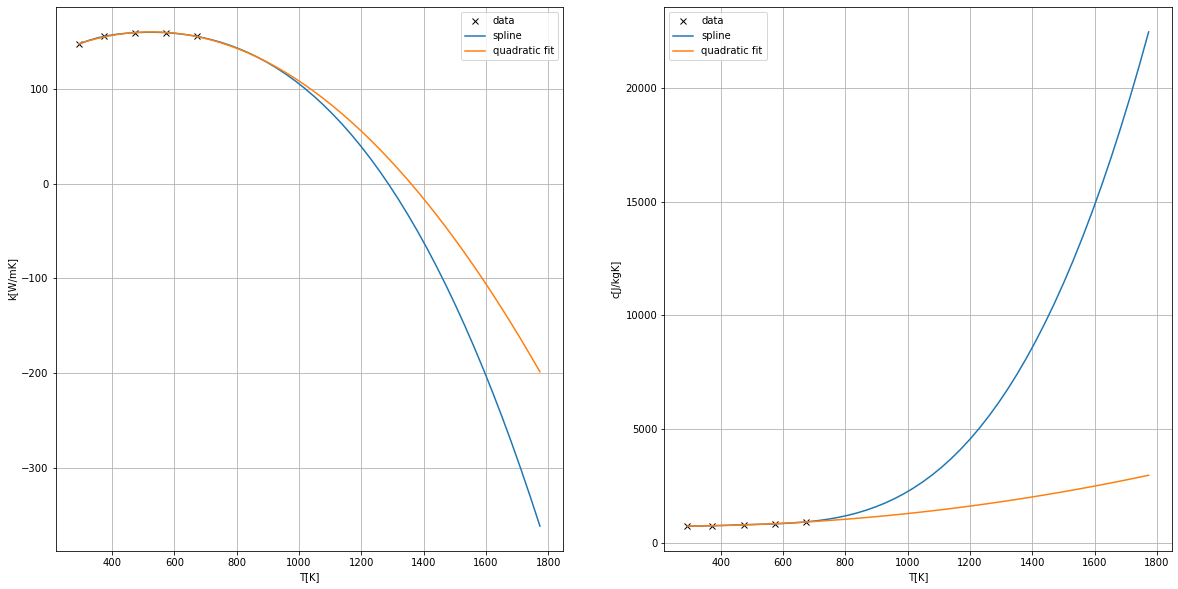

In [3]:
from scipy.optimize import curve_fit

T_range = np.linspace(20, 1500) + 273.15

def func(x, a, b, c):
    return a + b*x + c*x**2

k_interpolate = scipy.interpolate.CubicSpline(T, k_s)
c_interpolate = scipy.interpolate.CubicSpline(T, c)

p_k, q_k = curve_fit(func, T, k_s)
p_c, q_c = curve_fit(func, T, c)

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 10))

ax1.plot(T, k_s, 'kx', label = 'data')
ax1.plot(T_range, k_interpolate(T_range), label = 'spline')
ax1.plot(T_range, func(T_range, p_k[0], p_k[1], p_k[2]), label = 'quadratic fit')
ax1.set_xlabel('T[K]')
ax1.set_ylabel('k[W/mK]')
ax1.grid()
ax1.legend()

ax2.plot(T, c, 'kx', label = 'data')
ax2.plot(T_range, c_interpolate(T_range), label = 'spline')
ax2.plot(T_range, func(T_range, p_c[0], p_c[1], p_c[2]), label = 'quadratic fit')
ax2.set_xlabel('T[K]')
ax2.set_ylabel('c[J/kgK]')
ax2.grid()
ax2.legend()

Defining the geometry of the powderbed:

In [4]:
import deepxde as dde

dde.config.set_default_float("float64")
dde.config.set_random_seed(12345)

x = 1.54e-3
y = 0.7e-3
z = 0.1e-3

geo = dde.geometry.Hypercube((0.0, 0.0, 0.0), (x, y, z))

Set the default float type to float64


Defining the time and the domian:

In [5]:
t = 0.005

time = dde.geometry.TimeDomain(0.0, t)
domain = dde.geometry.GeometryXTime(geo, time)

Defining the other properties:

In [6]:
rho = 2650.0
A = 0.09
D = 70e-6
R = D/2
P = 250
v = 200e-3
T_0 = 273.15

Defining the top boundary neglecting the convection and radiation:

In [7]:
def top_bc(X):
    
    r_sq = (X[:,0] - x/4 - X[:,3]*v)**2 + (X[:,1] - y/2)**2
    
    return 2*A*P/(np.pi*R**2)*np.exp(-2*r_sq/R**2)

Plotting the end position of teh laser beam on the surface

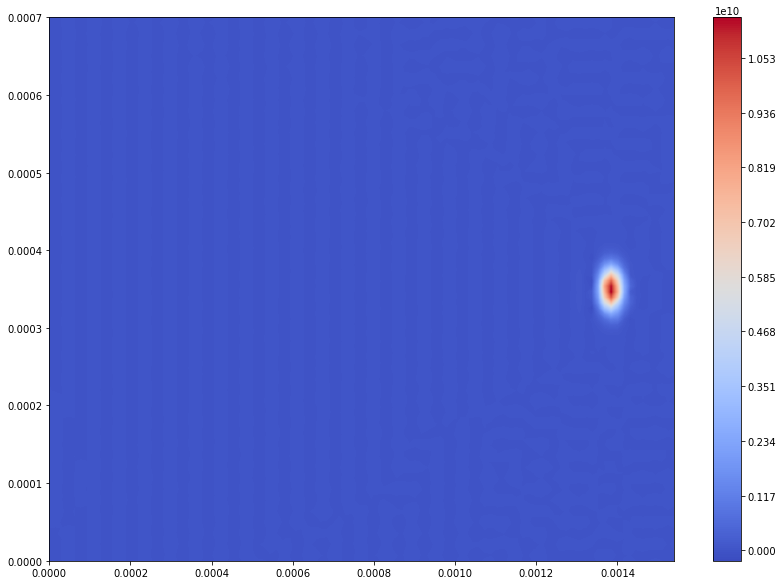

In [8]:
from scipy.interpolate import griddata

x_lin = np.linspace(0, x)
y_lin = np.linspace(0, y)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z], [0.005])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), top_bc(X), (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, yi, data, 1000, cmap=plt.cm.coolwarm)
plt.colorbar()

defining the pde system:

In [9]:
def pde_system(X, output):#
    
    T = output
    
    dT_dx = dde.grad.jacobian(T, X, j = 0)
    dT_dy = dde.grad.jacobian(T, X, j = 1)
    dT_dz = dde.grad.jacobian(T, X, j = 2)
    dT_dt = dde.grad.jacobian(T, X, j = 3)
    
    #k_eff = func(T, p_k[0], p_k[1], p_k[2])
    #c_eff = func(T, p_c[0], p_c[1], p_c[2])
    
    k_eff = 155
    c_eff = 922
    
    diff_T = dde.grad.jacobian(k_eff*dT_dx, X, j = 0) + dde.grad.jacobian(k_eff*dT_dy, X, j=1) + dde.grad.jacobian(k_eff*dT_dz, X, j = 2)
    
    f_T = dT_dt - diff_T/rho*c_eff
    
    return f_T

def dummy(X, output):
    return output

Defining initial and boundary conditions:

In [10]:
def top_bc_new(X):
    
    r_sq = (X[:,0:1] - x/4 - X[:,3:4]*v)**2 + (X[:,1:2] - y/2)**2
    
    return 2*A*P/(np.pi*R**2)*tf.exp(-2*r_sq/R**2)

ic = dde.icbc.IC(domain, lambda on_initial: 20 + T_0, lambda _, on_initial: on_initial)
#top = dde.icbc.NeumannBC(domain, top_bc(x), lambda on_boundary, x: on_boundary and np.isclose(x[2], z))
top = dde.icbc.RobinBC(domain, lambda X, y : top_bc_new(X)/155, lambda x, on_boundary: on_boundary and np.isclose(x[2], z, atol=z/10))
sides = dde.icbc.DirichletBC(domain, lambda X : 20 + T_0, lambda x, on_boundary: on_boundary and not np.isclose(x[2], z, atol=z/10))

creating the dataset:

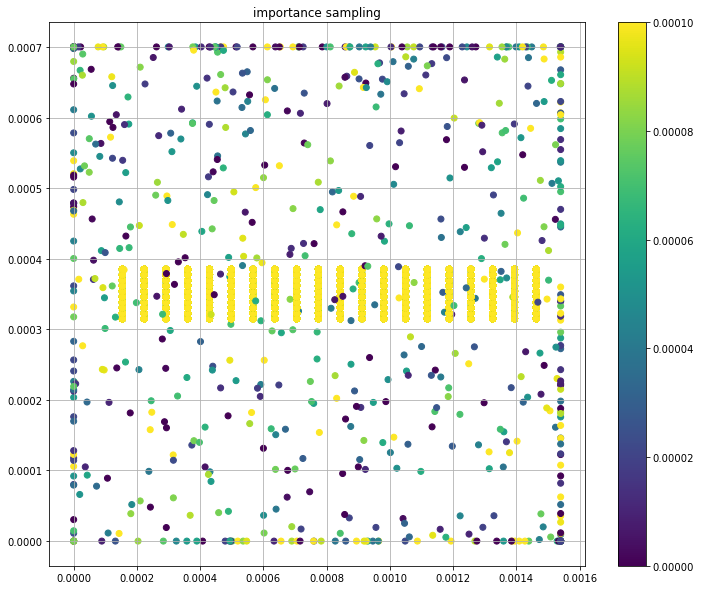

In [11]:
time = dde.geometry.TimeDomain(0.0, t)
domain = dde.geometry.GeometryXTime(geo, time)

#setting training points at the important part of the boundary
x_lin = np.linspace(0.1*x, 0.95*x, 20)
y_lin = np.linspace(0.45*y, 0.55*y, 10)
z_lin = np.linspace(0.9*z, z, 10)
t_lin = np.linspace(0, t, 10)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_lin], [t_lin])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

data = dde.data.TimePDE(domain,
                        pde_system,
                       ic_bcs=[top, sides],
                       num_domain=100,
                       num_initial=100,
                       num_boundary = 500,
                       train_distribution="pseudo",
                       anchors=X)

plt.figure(figsize = (12, 10))
plt.scatter(data.train_points().T[0], data.train_points().T[1], c = data.train_points().T[2])
plt.colorbar()
plt.title('importance sampling')
plt.grid()

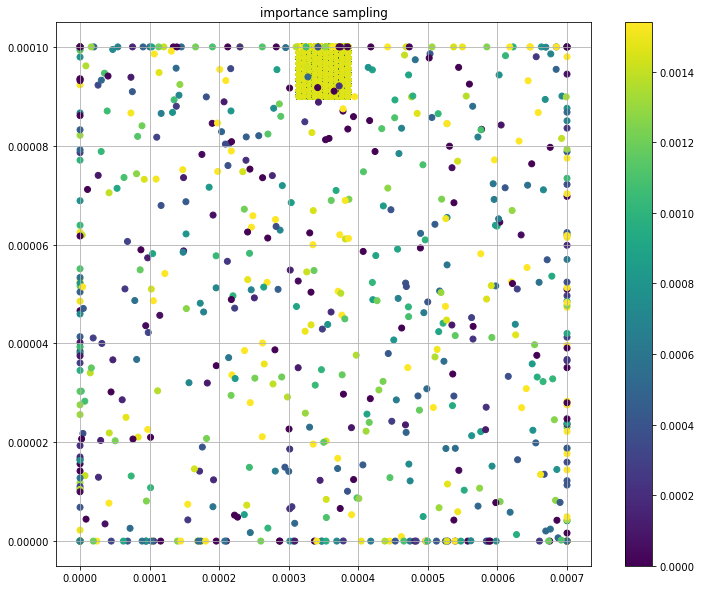

In [12]:
plt.figure(figsize = (12, 10))
plt.scatter(data.train_points().T[1], data.train_points().T[2], c = data.train_points().T[0])
plt.colorbar()
plt.title('importance sampling')
plt.grid()

In [13]:
#net = dde.nn.FNN([4] + [20] * 8 + [1], "sin", "Glorot normal")
net = dde.nn.MsFFN([4] + [20] * 4 + [1], "sin", "Glorot normal", sigmas = [1e-1, 1, 10])

def feature_transform(X):
    return tf.concat(
        [X[:, 0:1]/x, 
         X[:, 1:2]/y,
         X[:, 2:3]/z,
         X[:, 3:4]/t], axis=1
    )
net.apply_feature_transform(feature_transform)

def modify_output(X, Y):
    x, y, z, t = X[:, 0:1], X[:, 1:2], X[:, 2:3], X[:, 3:4]
    Temperature = Y
    T_new = t*Temperature*1000*1e1 + 20 + T_0
    return T_new
net.apply_output_transform(modify_output)

model = dde.Model(data, net)
model.compile("adam", lr=1e-5)
losshistory, train_state = model.train(epochs=0, display_every=1000)

Compiling model...
Building Multiscale Fourier Feature Network...


/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
2022-05-23 12:08:48.372626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 12:08:48.396144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 12:08:48.396489: I tensorflow/stream_execu

'compile' took 3.725645 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [9.39e+25, 5.02e+13, 1.47e+02]    [9.39e+25, 5.02e+13, 1.47e+02]    []  

Best model at step 0:
  train loss: 9.39e+25
  test loss: 9.39e+25
  test metric: []

'train' took 1.179199 s



In [14]:
weights = 1/np.array(losshistory.loss_train[0])
weights_2 = np.array([0, 1, 1])
model.compile("adam", lr=1e-3, loss_weights=weights*weights_2)
resampler = dde.callbacks.PDEResidualResampler(100)
losshistory, train_state = model.train(epochs=2000, display_every=1000, callbacks=[resampler])

Compiling model...
'compile' took 2.254534 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [0.00e+00, 1.11e+00, 2.73e+00]    [0.00e+00, 1.11e+00, 2.73e+00]    []  
1000      [0.00e+00, 4.12e-01, 4.33e-02]    [0.00e+00, 4.12e-01, 4.33e-02]    []  
2000      [0.00e+00, 5.19e-02, 4.16e-03]    [0.00e+00, 5.19e-02, 4.16e-03]    []  

Best model at step 2000:
  train loss: 5.61e-02
  test loss: 5.61e-02
  test metric: []

'train' took 485.699941 s



In [15]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 1000, display_every=100)

Compiling model...
'compile' took 2.030646 s

Training model...

Step      Train loss                        Test loss                         Test metric
2000      [0.00e+00, 5.19e-02, 4.16e-03]    [0.00e+00, 5.19e-02, 4.16e-03]    []  
2100      [0.00e+00, 3.40e-02, 7.75e-04]                                          
2200      [0.00e+00, 3.23e-02, 2.31e-04]                                          
2300      [0.00e+00, 3.18e-02, 1.29e-04]                                          
2400      [0.00e+00, 3.15e-02, 8.30e-05]                                          
2500      [0.00e+00, 3.14e-02, 6.05e-05]                                          
2600      [0.00e+00, 3.13e-02, 4.49e-05]                                          
2700      [0.00e+00, 3.13e-02, 3.31e-05]                                          
2800      [0.00e+00, 3.13e-02, 2.60e-05]                                          
2900      [0.00e+00, 3.12e-02, 2.56e-05]                                          
3000      [0.00

In [16]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 1000, display_every=100)

Compiling model...
'compile' took 2.259819 s

Training model...

Step      Train loss                        Test loss                         Test metric
3030      [0.00e+00, 3.12e-02, 1.72e-05]    [0.00e+00, 3.12e-02, 1.72e-05]    []  
3100      [0.00e+00, 3.12e-02, 1.39e-05]                                          
3200      [0.00e+00, 3.12e-02, 1.20e-05]                                          
3300      [0.00e+00, 3.12e-02, 1.04e-05]                                          
3400      [0.00e+00, 3.12e-02, 8.88e-06]                                          
3500      [0.00e+00, 3.12e-02, 7.74e-06]                                          
3600      [0.00e+00, 3.12e-02, 6.89e-06]                                          
3700      [0.00e+00, 3.11e-02, 6.37e-06]                                          
3800      [0.00e+00, 3.11e-02, 5.90e-06]                                          
3900      [0.00e+00, 3.11e-02, 5.57e-06]                                          
4000      [0.00

In [17]:
weights_2 = np.array([1, 1, 1])
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=10000, maxfun=None, maxls=50)
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 1000, display_every=100)

Compiling model...
'compile' took 2.274199 s

Training model...

Step      Train loss                        Test loss                         Test metric
4073      [5.89e+02, 3.11e-02, 4.38e-06]    [5.87e+02, 3.11e-02, 4.38e-06]    []  
4100      [3.10e+00, 9.77e-01, 1.10e-01]                                          
4200      [5.51e-03, 9.80e-01, 9.03e-04]                                          
4300      [2.80e-03, 9.79e-01, 6.05e-04]                                          
4400      [3.80e-03, 9.75e-01, 1.39e-03]                                          
4500      [5.80e-03, 9.69e-01, 2.22e-03]                                          
4600      [6.98e-03, 9.59e-01, 5.72e-03]                                          
4700      [9.31e-03, 9.46e-01, 5.65e-03]                                          
4800      [1.22e-02, 9.30e-01, 5.31e-03]                                          
4900      [1.84e-02, 9.04e-01, 7.97e-03]                                          
5000      [5.08

13700     [3.53e-02, 1.94e-01, 5.05e-03]                                          
13800     [3.52e-02, 1.93e-01, 4.94e-03]                                          
13900     [3.51e-02, 1.93e-01, 4.66e-03]                                          
14000     [3.53e-02, 1.92e-01, 4.50e-03]                                          
14100     [3.50e-02, 1.91e-01, 4.52e-03]                                          
14200     [3.48e-02, 1.90e-01, 4.66e-03]                                          
14300     [3.54e-02, 1.89e-01, 4.62e-03]                                          
14400     [3.54e-02, 1.88e-01, 4.65e-03]                                          
14500     [3.54e-02, 1.87e-01, 4.73e-03]                                          
14600     [3.52e-02, 1.86e-01, 4.95e-03]                                          
14700     [3.50e-02, 1.86e-01, 5.19e-03]                                          
14800     [3.58e-02, 1.84e-01, 5.17e-03]                                          
INFO

In [26]:
weights_2 = np.array([1, 1, 1])
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 1000, display_every=100)

Compiling model...
'compile' took 2.550165 s

Training model...

Step      Train loss                        Test loss                         Test metric
14810     [3.59e-02, 1.84e-01, 5.25e-03]    [5.68e-02, 1.84e-01, 5.25e-03]    []  
14900     [3.52e-02, 1.84e-01, 4.98e-03]                                          
15000     [3.48e-02, 1.84e-01, 4.71e-03]                                          
15100     [3.46e-02, 1.84e-01, 4.57e-03]                                          
15200     [3.42e-02, 1.84e-01, 4.21e-03]                                          
15300     [3.39e-02, 1.84e-01, 3.84e-03]                                          
15400     [3.36e-02, 1.83e-01, 3.52e-03]                                          
15500     [3.30e-02, 1.83e-01, 3.43e-03]                                          
15600     [3.20e-02, 1.84e-01, 3.30e-03]                                          
15700     [3.19e-02, 1.83e-01, 3.14e-03]                                          
15800     [3.19

In [33]:
weights_2 = np.array([1, 1, 1])
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 1000, display_every=100)

Compiling model...
'compile' took 2.804058 s

Training model...

Step      Train loss                        Test loss                         Test metric
15874     [3.17e-02, 1.83e-01, 3.07e-03]    [6.16e-02, 1.83e-01, 3.07e-03]    []  
15900     [3.17e-02, 1.83e-01, 3.07e-03]                                          
16000     [3.14e-02, 1.83e-01, 2.88e-03]                                          
16100     [3.15e-02, 1.83e-01, 2.78e-03]                                          
16200     [3.15e-02, 1.82e-01, 2.72e-03]                                          
16300     [3.16e-02, 1.82e-01, 2.67e-03]                                          
16400     [3.15e-02, 1.81e-01, 2.68e-03]                                          
16500     [3.12e-02, 1.81e-01, 2.75e-03]                                          
16600     [3.13e-02, 1.81e-01, 2.80e-03]                                          
16700     [3.12e-02, 1.80e-01, 2.92e-03]                                          
16800     [3.15

In [39]:
weights_2 = np.array([1, 1, 1])
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=5000, maxfun=None, maxls=50)
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 1000, display_every=100)

Compiling model...
'compile' took 2.669107 s

Training model...

Step      Train loss                        Test loss                         Test metric
16935     [3.18e-02, 1.78e-01, 3.26e-03]    [6.58e-02, 1.78e-01, 3.26e-03]    []  
17000     [3.18e-02, 1.78e-01, 3.17e-03]                                          
17100     [3.15e-02, 1.78e-01, 3.04e-03]                                          
17200     [3.11e-02, 1.79e-01, 2.95e-03]                                          
17300     [3.09e-02, 1.79e-01, 2.87e-03]                                          
17400     [3.08e-02, 1.78e-01, 2.76e-03]                                          
17500     [3.07e-02, 1.78e-01, 2.68e-03]                                          
17600     [3.08e-02, 1.78e-01, 2.64e-03]                                          
17700     [3.06e-02, 1.78e-01, 2.64e-03]                                          
17800     [3.03e-02, 1.78e-01, 2.64e-03]                                          
17900     [3.03

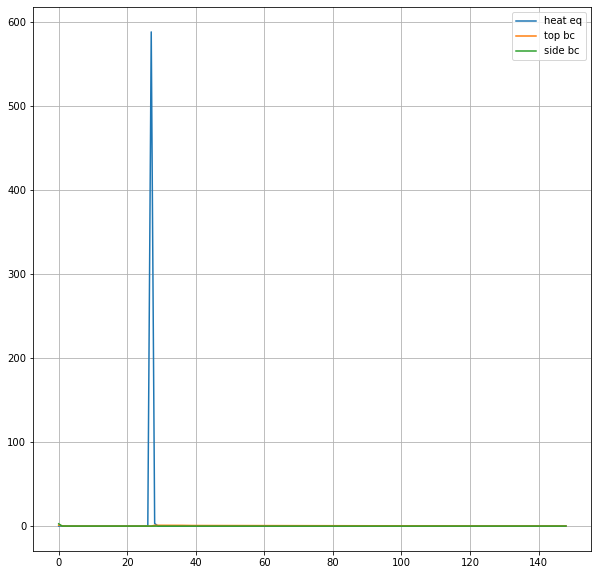

In [27]:
loss_names = ['heat eq', 'top bc', 'side bc']
n = 1
plt.figure(figsize = (10, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(loss[n:], label = name)

plt.grid()
plt.legend()

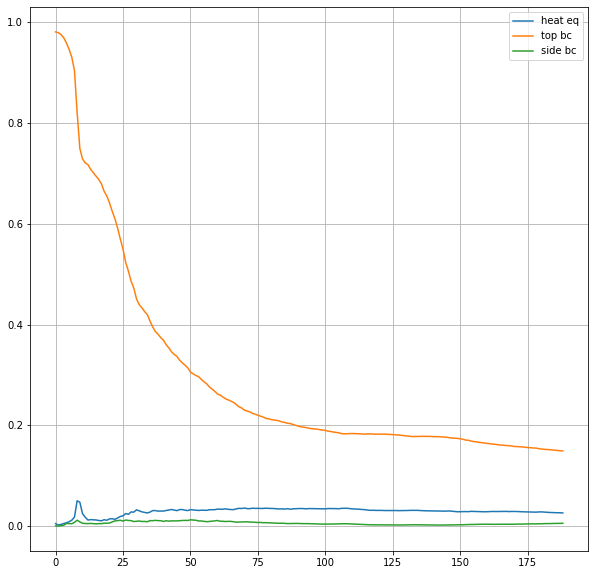

In [40]:
loss_names = ['heat eq', 'top bc', 'side bc']
n = 30
plt.figure(figsize = (10, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(loss[n:], label = name)

plt.grid()
plt.legend()

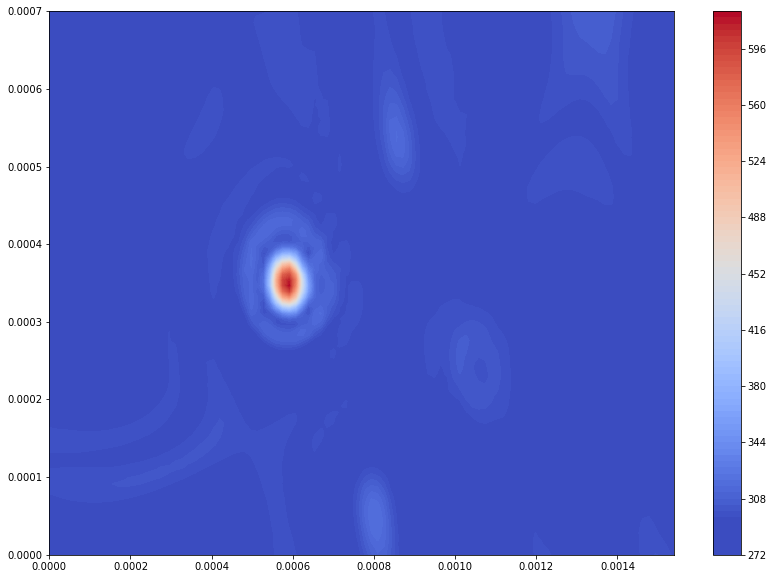

In [51]:
x_lin = np.linspace(0, x)
y_lin = np.linspace(0, y)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z], [0.2*t])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm, vmin = 273.15 + 20)
plt.colorbar()

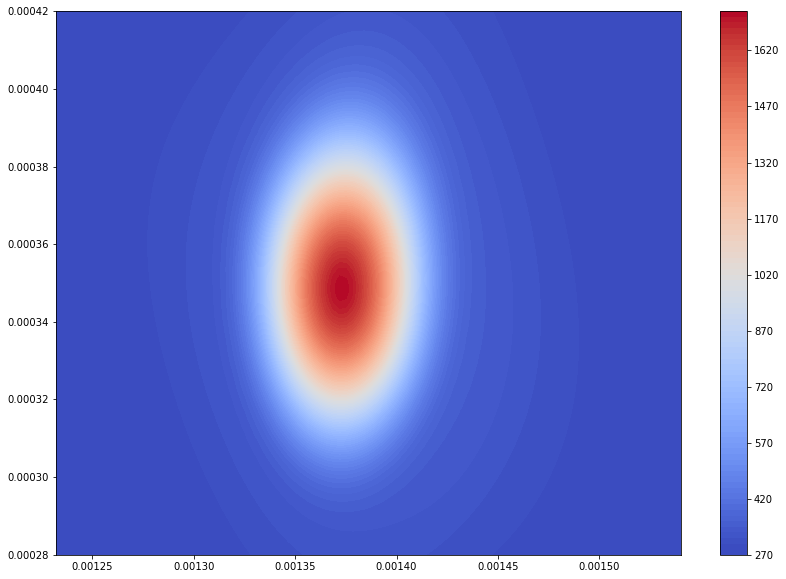

In [49]:
x_lin = np.linspace(0.8*x, x)
y_lin = np.linspace(0.4*y, 0.6*y)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z], [t])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm, vmin = 273.15 + 20)
plt.colorbar()

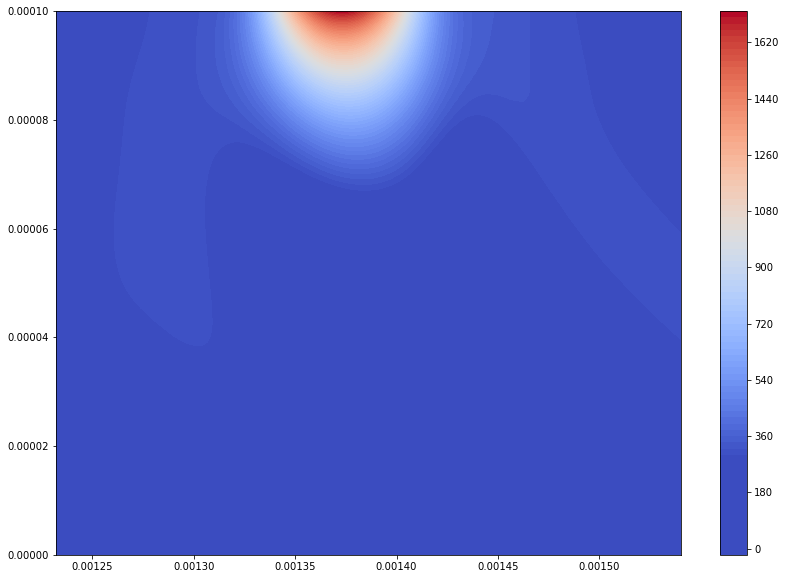

In [44]:
x_lin = np.linspace(0.8*x, x)
z_lin = np.linspace(0, z)
xx, yy, zz, tt = np.meshgrid(x_lin, [y/2], z_lin, [t])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
zi = np.linspace(zz.min(), zz.max(), 100)
data = griddata((np.ravel(xx), np.ravel(zz)), Y[:,0], (xi[None,:], zi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, zi, data, 100, cmap=plt.cm.coolwarm, vmin = 273.15 + 20)
plt.colorbar()

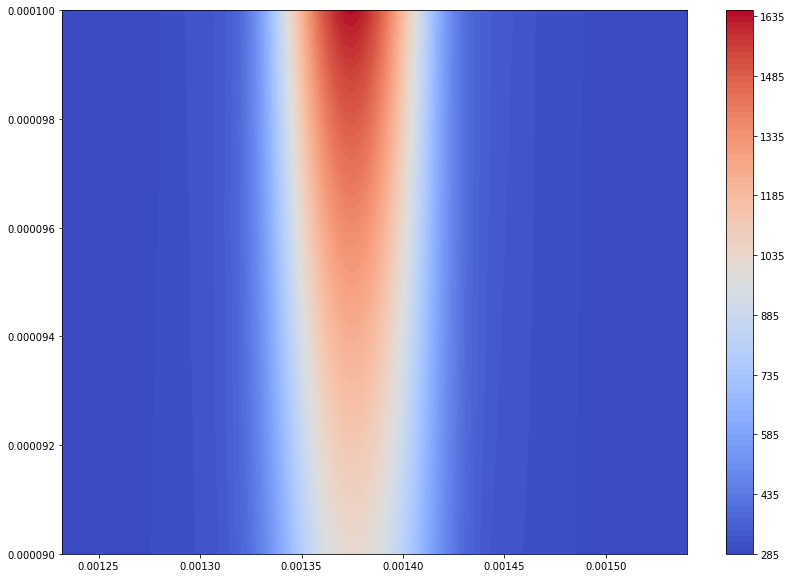

In [38]:
x_lin = np.linspace(0.8*x, x)
z_lin = np.linspace(0.9*z, z)
xx, yy, zz, tt = np.meshgrid(x_lin, [y/2], z_lin, [t])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
zi = np.linspace(zz.min(), zz.max(), 100)
data = griddata((np.ravel(xx), np.ravel(zz)), Y[:,0], (xi[None,:], zi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, zi, data, 100, cmap=plt.cm.coolwarm, vmin = 273.15 + 20)
plt.colorbar()

In [52]:
data.min()

273.875017148457

In [34]:
model.save('precicion/')

INFO:tensorflow:precicion/-17409.ckpt is not in all_model_checkpoint_paths. Manually adding it.


'precicion/-17409.ckpt'

In [55]:
ref_data = data = np.genfromtxt('of_data/end_data.csv', delimiter = ',',skip_header = True)

In [60]:
ref_data.shape

(1030301, 5)

In [79]:
X = ref_data[:,0:3].T
t_value = np.ones(len(X[0]))*t
X = np.vstack((X, t_value)).T

In [80]:
Y = model.predict(X)

In [92]:
diff = np.abs(Y.T[0] - ref_data[:,3:4].T)

In [93]:
diff.mean()

11.54641981210365

In [96]:
diff.var()

1135.663615980894

In [94]:
diff.max()

606.0139373342597

In [95]:
diff.min()

3.910551299668441e-06

In [ ]:
plt.hist(diff)